In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)

AUTOTUNE = tf.data.AUTOTUNE

from shared_funcs import multi_label_binary_encode_tensor, multi_label_binary_decode_tensor, get_waveform, split_into_windows, split_into_sequences 

In [44]:
ALL_LABELS = tf.constant(['p', 'g', 'slash', '7', 'equal', 'w', 'a', 'dash', 'caps', 'l', 'd', 'backspace', 'bracketclose', 'z', '1', 'comma', 'c', 'tab', 'b', 'j', 'Lctrl', 'n', 't', 'f', 'm', 'o', 'apostrophe', 'y', '8', 'space', 'backslash', 's', '9', 'i', 'r', 'bracketopen', 'semicolon', 'q', '5', 'k', '3', 'x', '4', '6', '2', 'Lshift', 'backtick', 'enter', 'fullstop', 'e', '0', 'h', 'v', 'u'], dtype=tf.string)

### Load Datasets

In [45]:
# Load MKA Dataset
# mka_path = os.path.dirname(os.getcwd()) + "/data-manipulation/mka_dataset"
# mka_dataset = tf.data.Dataset.load(mka_path)

# Load supplementary dataset
supp_path = os.path.dirname(os.getcwd()) + "/data-manipulation/supp_dataset"
supp_dataset = tf.data.Dataset.load(supp_path)

supp_dataset = supp_dataset.shuffle(256)

# mka_dataset.cache()
supp_dataset.cache()
# mka_dataset = mka_dataset.prefetch(tf.data.AUTOTUNE)
supp_dataset = supp_dataset.prefetch(AUTOTUNE)

# print(f"MKA Dataset {mka_dataset.element_spec}\nLength: {tf.data.experimental.cardinality(mka_dataset).numpy()}")
print(f"Supp Dataset {supp_dataset.element_spec}\nLength: {tf.data.experimental.cardinality(supp_dataset).numpy()}")

spectrogram_dataset = supp_dataset

# Add channel dimension for conv network
spectrogram_dataset = spectrogram_dataset.map(
    lambda spectrogram, label: (tf.expand_dims(spectrogram, axis=-1), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

Supp Dataset (TensorSpec(shape=(19, 111), dtype=tf.float32, name=None), TensorSpec(shape=(54,), dtype=tf.int32, name=None))
Length: 11886


### Analyze Dataset

Labels in ALL_LABELS but not in my labels: []
Dataset size  11886


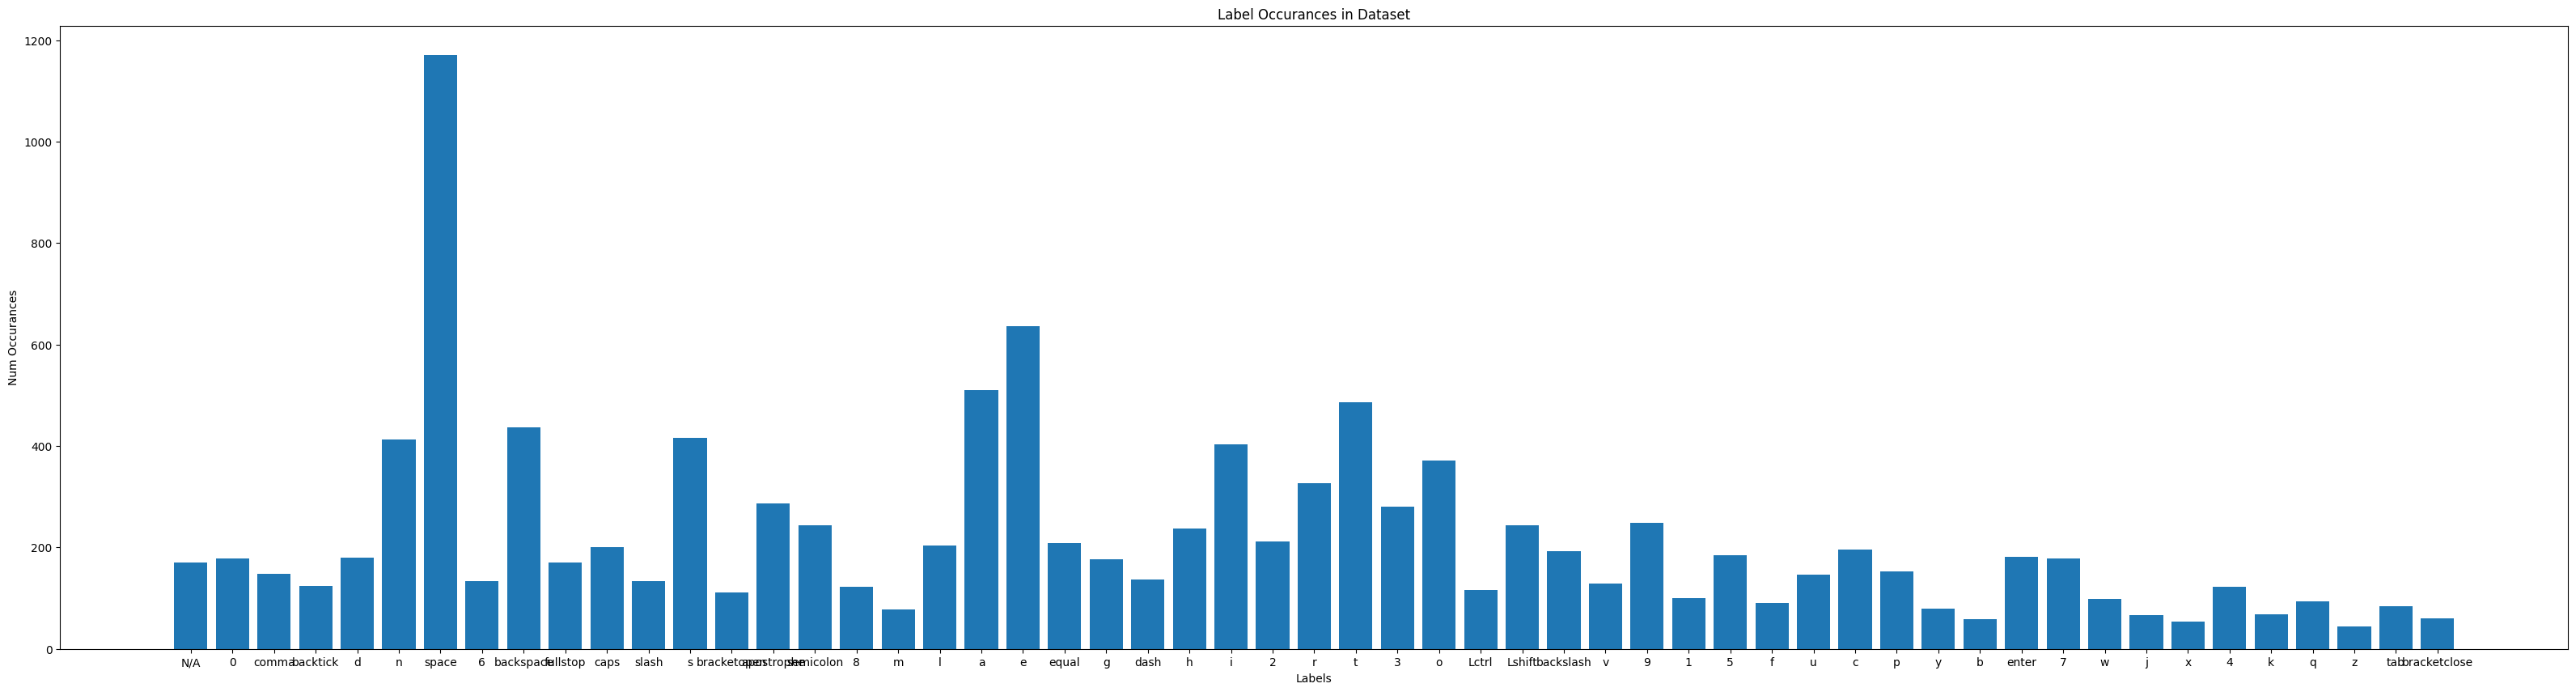

In [46]:
dataset_size = 0
labels = []
label_occurances = []
for spectrogram, label in spectrogram_dataset:
    dataset_size += 1
    label = multi_label_binary_decode_tensor(tf, label)
    if label:
        label = label[0]
        if label in labels:
            index = labels.index(label)
            label_occurances[index] += 1
        else:
            labels.append(label)
            label_occurances.append(1)
# print(len(labels))
# print(len(label_occurances))

labels_tensor = tf.constant(labels, dtype=tf.string)

difference = tf.sets.difference(tf.expand_dims(ALL_LABELS, axis=0), 
                                tf.expand_dims(labels_tensor, axis=0))

# Convert sparse result to dense
missing_labels = tf.sparse.to_dense(difference)[0].numpy()

print("Labels in ALL_LABELS but not in my labels:", missing_labels)
print("Dataset size ", dataset_size)

# Insert no label/noise
labels.insert(0, "N/A")
label_occurances.insert(0, dataset_size - sum(label_occurances))

plt.figure(figsize=(40,10))
plt.bar(labels, label_occurances)
plt.title("Label Occurances in Dataset")
plt.xlabel("Labels")
plt.ylabel("Num Occurances")
plt.show()

### Prepare Dataset for Training

In [47]:
dataset_size = sum(1 for _ in spectrogram_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

# Split into train val and test datasets
train_dataset = spectrogram_dataset.take(train_size)
remaining_dataset = spectrogram_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

print("Train Dataset Size: ", sum(1 for _ in train_dataset))
print("Validation Dataset Size: ", sum(1 for _ in val_dataset))
print("Test Dataset Size: ", sum(1 for _ in test_dataset))


Train Dataset Size:  9508
Validation Dataset Size:  1188
Test Dataset Size:  1190


2024-12-09 18:37:11.945523: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Calculate Class Weights
Since the dataset may be imbalanced with different classes, especially with the no key pressed class, we must calculate the class weights so the model is not biased towards the majority class

In [48]:
def calculate_class_weights(labels):
    num_classes = labels.shape[1]
    class_counts = np.sum(labels, axis=0)
    total_counts = np.sum(class_counts)

    class_weights = {
        i: total_counts / (num_classes * class_counts[i]) if class_counts[i] > 0 else 0
        for i in range(num_classes)
    }
    return class_weights

# Example usage
all_labels = np.stack([label.numpy() for _, label in train_dataset])
class_weights = calculate_class_weights(all_labels)
print("Class Weights:", class_weights)

Class Weights: {0: 1.471210706504824, 1: 1.2416600998161282, 2: 1.9029790660225443, 3: 1.3163464216095795, 4: 1.1368446368446368, 5: 2.0357450473729544, 6: 0.4259709831485987, 7: 1.8236882716049383, 8: 1.1518031189083822, 9: 1.0740740740740742, 10: 1.1909800957420005, 11: 0.4681124975242622, 12: 3.978956228956229, 13: 6.733618233618234, 14: 2.2445394112060777, 15: 1.549328089151098, 16: 1.1222697056030388, 17: 3.0185185185185186, 18: 3.5729402872260017, 19: 3.366809116809117, 20: 1.9238909238909239, 21: 0.5149237472766884, 22: 0.4559220679012346, 23: 2.334320987654321, 24: 2.3982749873160834, 25: 0.5684223184223184, 26: 0.7678687459389214, 27: 2.334320987654321, 28: 1.768424990647213, 29: 0.18585358181961154, 30: 1.0675248419150858, 31: 0.5454020999192338, 32: 0.9619454619454619, 33: 0.5337624209575429, 34: 0.6581732108047897, 35: 2.0123456790123457, 36: 0.8624338624338624, 37: 2.501058201058201, 38: 1.1749937857320407, 39: 3.3032844164919637, 40: 0.8417022792022792, 41: 4.376851851851

### Batch and Prefetch datasets

In [49]:
print("Test Dataset Size: ", sum(1 for _ in test_dataset))

# Batch and prefetch
train_dataset = train_dataset.batch(32).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=AUTOTUNE)
print("Test Dataset Size: ", sum(1 for _ in test_dataset))

Test Dataset Size:  1190
Test Dataset Size:  38


# Model

In [50]:
print(spectrogram_dataset.element_spec)
model = Sequential([
    layers.Input(shape=(19, 111, 1)),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(),
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(54, activation="sigmoid")
])

model.summary()

(TensorSpec(shape=(19, 111, 1), dtype=tf.float32, name=None), TensorSpec(shape=(54,), dtype=tf.int32, name=None))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 19, 111, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 19, 111, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 19, 111, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 9, 55, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 9, 55, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     1,769,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 54)             │         3,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,874,038 (7.15 MB)

 Trainable params: 1,874,038 (7.15 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=["accuracy", keras.metrics.Precision()]
)

model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    class_weight=class_weights
)

Epoch 1/30


298/298 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.0213 - loss: 0.3005 - precision_3: 0.0186 - val_accuracy: 0.0109 - val_loss: 0.0927 - val_precision_3: 0.0000e+00
Epoch 2/30
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0173 - loss: 0.1062 - precision_3: 0.0104 - val_accuracy: 0.0168 - val_loss: 0.0919 - val_precision_3: 0.0000e+00
Epoch 3/30
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0188 - loss: 0.1007 - precision_3: 0.0000e+00 - val_accuracy: 0.0354 - val_loss: 0.0920 - val_precision_3: 0.0000e+00
Epoch 4/30
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0302 - loss: 0.0982 - precision_3: 0.2240 - val_accuracy: 0.0572 - val_loss: 0.0881 - val_precision_3: 0.6000
Epoch 5/30
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0580 - loss: 0.0944 - precision_3: 0.4267 - val_accuracy: 0.1002 - val_loss: 0.0835 - val_precision_3: 0.3684
Epoch 6/30
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0904 - loss: 0.0905 - precision_3: 0.6140 - val_

## Evaluate Model

In [52]:
def decode_predictions(binary_vector):
    binary_predictions = tf.convert_to_tensor(binary_vector, dtype=tf.int32)

    decoded_predictions = []
    for sample_predictions in binary_predictions:  # Iterate over batch
        indices = tf.where(sample_predictions > 0)  # Indices of positive predictions
        decoded = [ALL_LABELS[i] for i in tf.reshape(indices, [-1]).numpy()]  # Map indices to labels
        decoded_predictions.append(decoded)
    return decoded_predictions

# (TP + TN) / (TP + TN + FP + FN)
def evaluate_accuracy():
    pass

# TP / (TP + FP)
def evaluate_precision():
    pass

In [53]:
loss, accuracy, precision = model.evaluate(test_dataset)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4056 - loss: 0.0598 - precision_3: 0.8265
Loss: 0.0583462193608284, Accuracy: 0.4075630307197571, Precision: 0.7968254089355469


In [54]:
def calculate_metrics_aggregated_per_label(model, test_dataset):
    label_count = len(ALL_LABELS)
    tp = [0] * label_count
    fp = [0] * label_count
    fn = [0] * label_count
    tn = [0] * label_count

    batch_count = 0
    total_samples = 0

    for features, labels in test_dataset:
        batch_count += 1
        print(f"Processing batch {batch_count}...")

        # Predict for the current batch
        predictions = model.predict(features, verbose=0)
        predictions = (predictions > 0.5).astype(int)

        total_samples += labels.shape[0]

        for label_idx in range(labels.shape[1]):
            true_label = labels.numpy()[:, label_idx]
            predicted_label = predictions[:, label_idx]

            # Calculate confusion matrix
            try:
                tn_batch, fp_batch, fn_batch, tp_batch = confusion_matrix(
                    true_label, predicted_label, labels=[0, 1]
                ).ravel()
            except ValueError:
                # label has no positive predictions
                tn_batch = fp_batch = fn_batch = tp_batch = 0
                if np.all(true_label == 0):
                    tn_batch = len(true_label)
                elif np.all(true_label == 1):
                    fn_batch = len(true_label)

            # Aggregate the confusion matrix values across batches
            tp[label_idx] += tp_batch
            fp[label_idx] += fp_batch
            fn[label_idx] += fn_batch
            tn[label_idx] += tn_batch

    label_metrics = {}
    for label_idx in range(label_count):
        precision = tp[label_idx] / (tp[label_idx] + fp[label_idx]) if (tp[label_idx] + fp[label_idx]) > 0 else 0.0
        accuracy = (tp[label_idx] + tn[label_idx]) / (tp[label_idx] + fp[label_idx] + fn[label_idx] + tn[label_idx])

        label_metrics[f"Label {ALL_LABELS[label_idx]}"] = {
            "Precision": precision,
            "Accuracy": accuracy,
            "TP": tp[label_idx],
            "FP": fp[label_idx],
            "FN": fn[label_idx],
            "TN": tn[label_idx],
        }

    total_tp = sum(tp)
    total_fp = sum(fp)
    total_fn = sum(fn)
    total_tn = sum(tn)

    micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    micro_accuracy = (total_tp + total_tn) / (total_tp + total_fp + total_fn + total_tn)

    print(f"Processed {batch_count} batches and {total_samples} total samples.")
    print(f"Micro-Averaged Precision: {micro_precision:.2f}")
    print(f"Micro-Averaged Accuracy: {micro_accuracy:.2f}")

    return label_metrics, {"Micro Precision": micro_precision, "Micro Accuracy": micro_accuracy}

label_metrics, micro_metrics = calculate_metrics_aggregated_per_label(model, test_dataset)

highest_acc_class = ""
highest_acc = 0
highest_prec_class = ""
highest_prec = 0

aggregate_TP = 0
aggregate_TN = 0
aggregate_FP = 0
aggregate_FN = 0

for label, metrics in label_metrics.items():
    aggregate_TP += metrics["TP"]
    aggregate_TN += metrics["TN"]
    aggregate_FP += metrics["FP"]
    aggregate_FN += metrics["FN"]
    
    if metrics["Accuracy"] > highest_acc:
        highest_acc = metrics["Accuracy"]
        highest_acc_class=  label
    
    if metrics["Precision"] > highest_prec:
        highest_prec = metrics["Precision"]
        highest_prec_class = label

    print(f"{label} -> Precision: {metrics['Precision']:.2f}, Accuracy: {metrics['Accuracy']:.2f}, "
          f"TP: {metrics['TP']}, FP: {metrics['FP']}, FN: {metrics['FN']}, TN: {metrics['TN']}")

print(f"Micro Precision: {micro_metrics['Micro Precision']:.2f}")
print(f"Micro Accuracy: {micro_metrics['Micro Accuracy']:.2f}")

print(f"Aggregate Results: TP: {aggregate_TP}, TN: {aggregate_TN}, FP: {aggregate_FP}, FN: {aggregate_FN}")
print(f"Highest Accuracy Class: {highest_acc_class}: {highest_acc}")
print(f"Highest Precision Class: {highest_prec_class}: {highest_prec}")


Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...
Processing batch 8...
Processing batch 9...
Processing batch 10...
Processing batch 11...
Processing batch 12...
Processing batch 13...
Processing batch 14...
Processing batch 15...
Processing batch 16...
Processing batch 17...
Processing batch 18...
Processing batch 19...
Processing batch 20...
Processing batch 21...
Processing batch 22...
Processing batch 23...
Processing batch 24...
Processing batch 25...
Processing batch 26...
Processing batch 27...
Processing batch 28...
Processing batch 29...
Processing batch 30...
Processing batch 31...
Processing batch 32...
Processing batch 33...
Processing batch 34...
Processing batch 35...
Processing batch 36...
Processing batch 37...
Processing batch 38...
Processed 38 batches and 1190 total samples.
Micro-Averaged Precision: 0.80
Micro-Averaged Accuracy: 0.98
Label b'p' -> Precision: 0.00

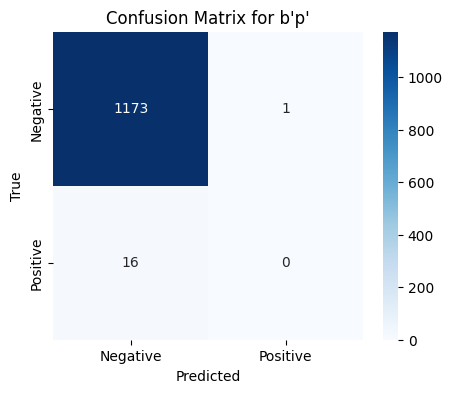

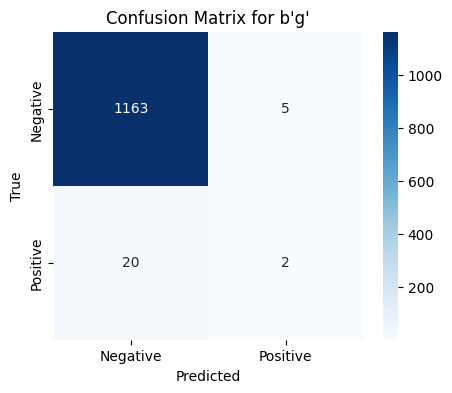

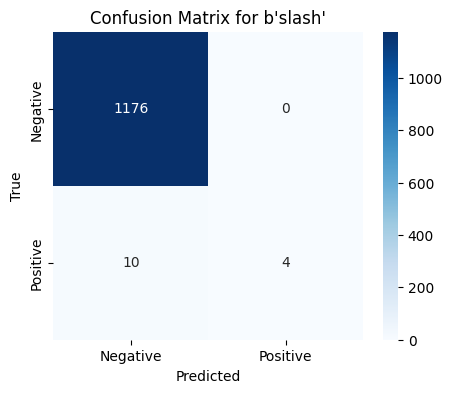

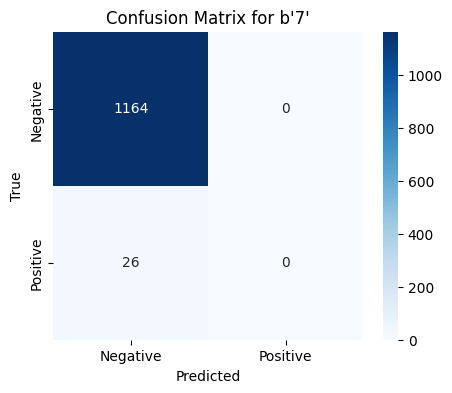

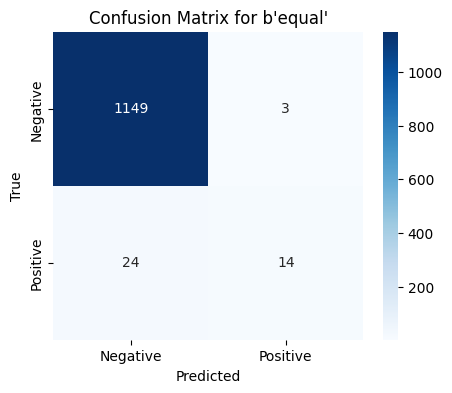

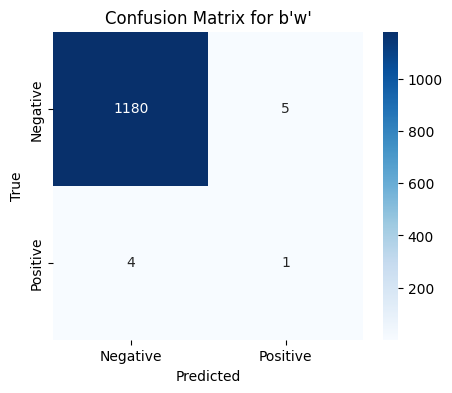

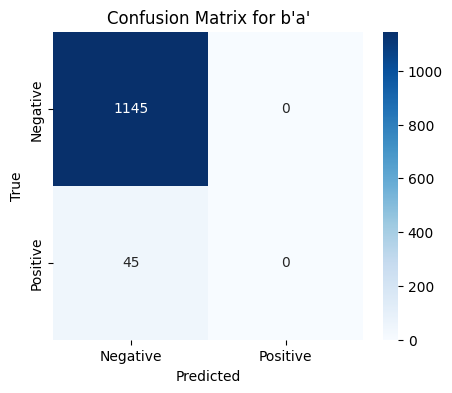

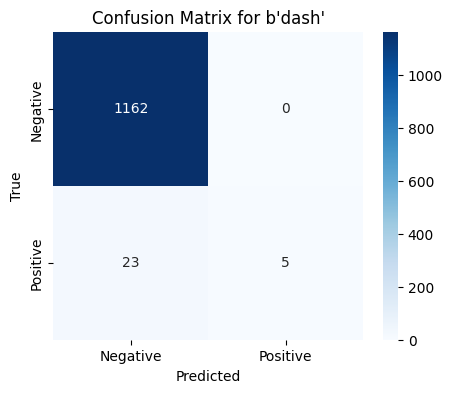

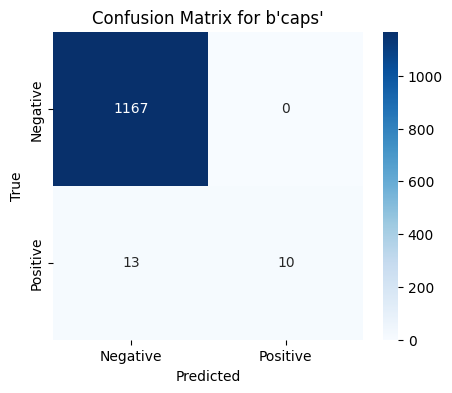

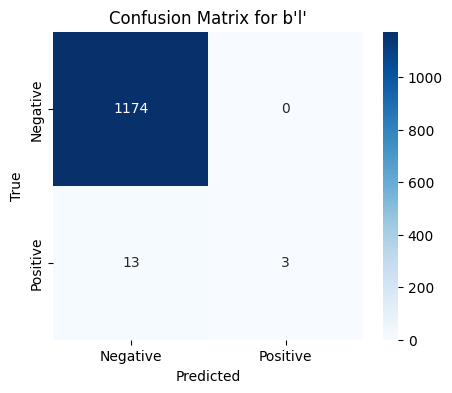

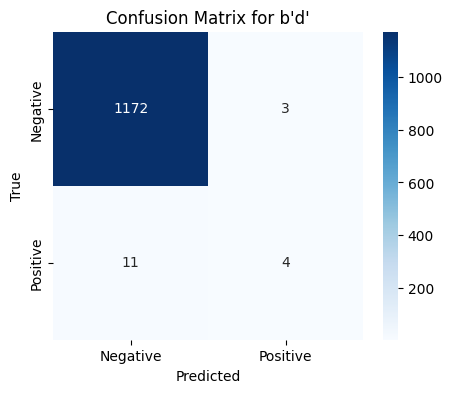

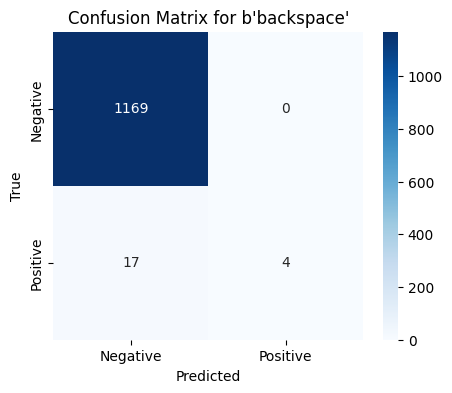

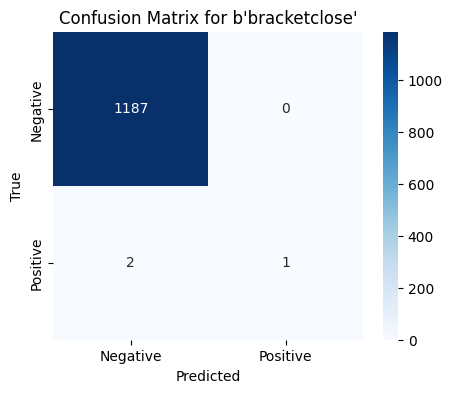

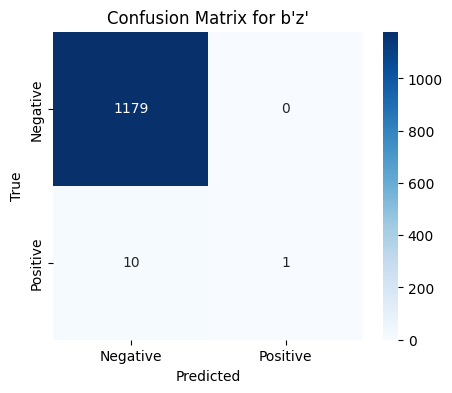

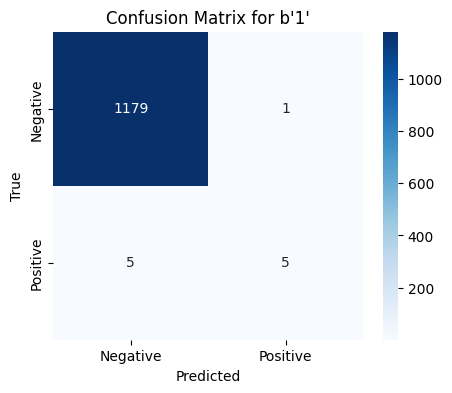

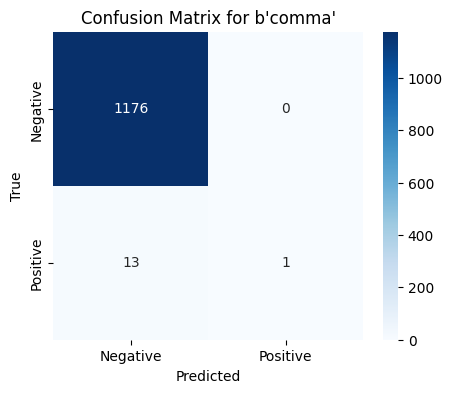

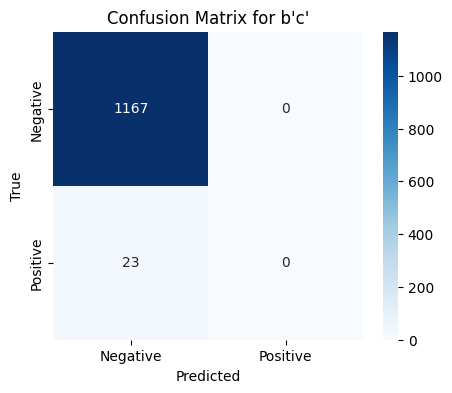

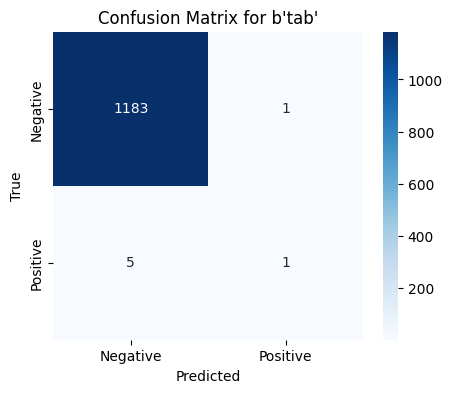

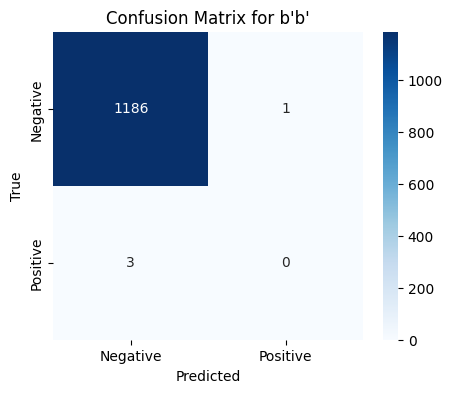

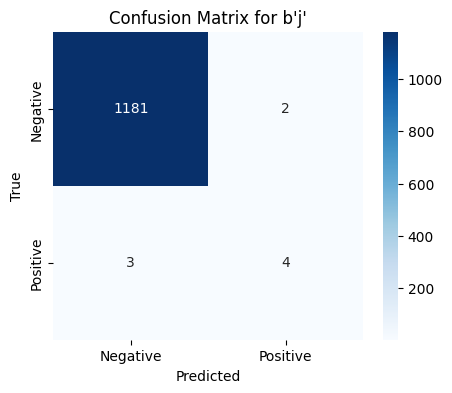

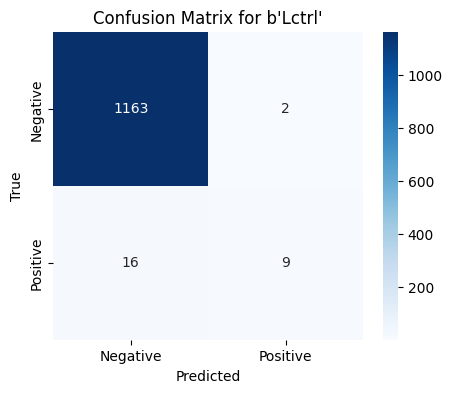

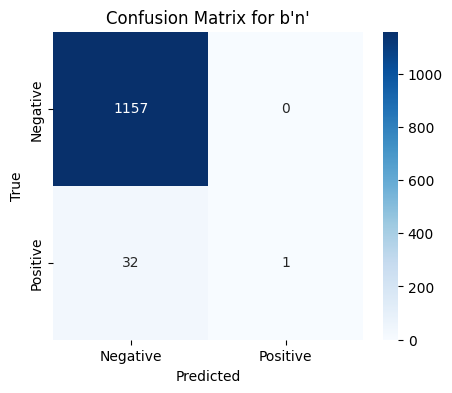

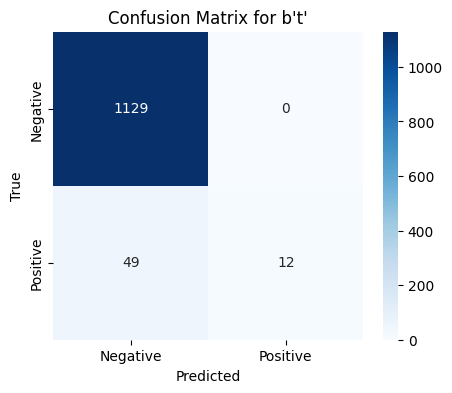

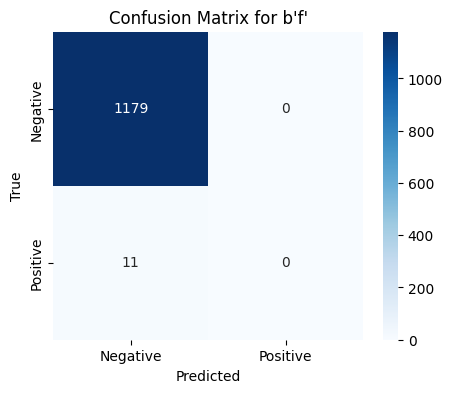

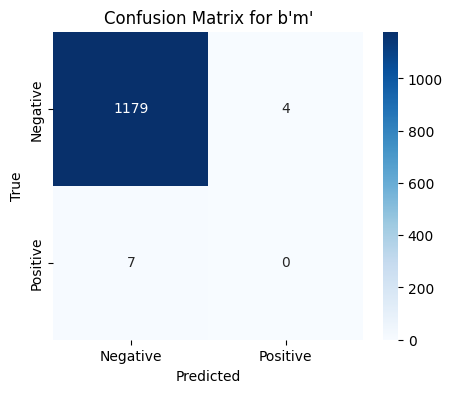

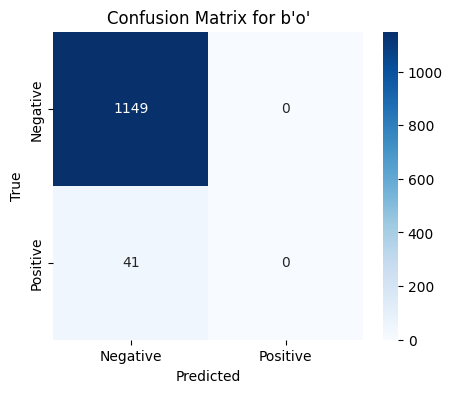

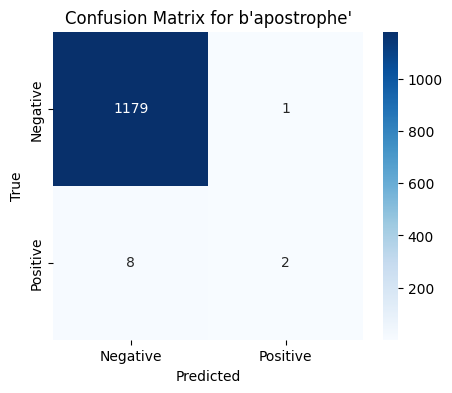

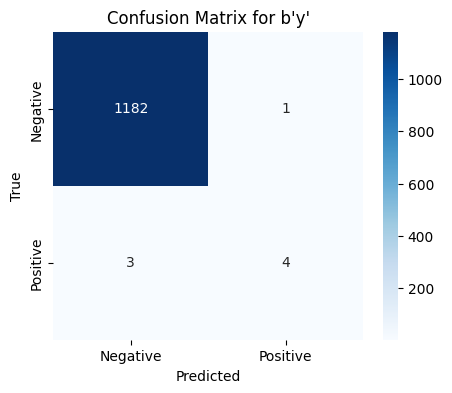

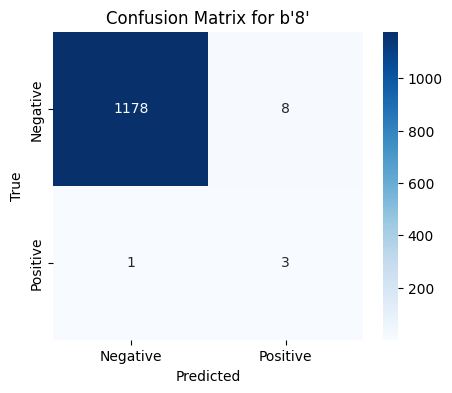

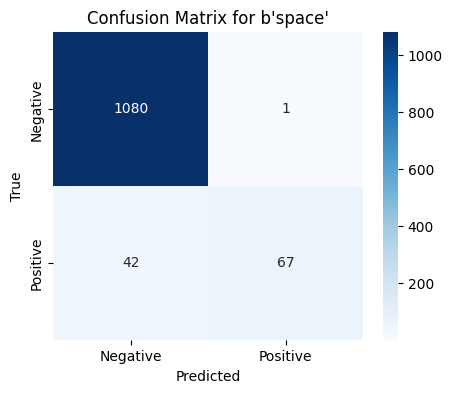

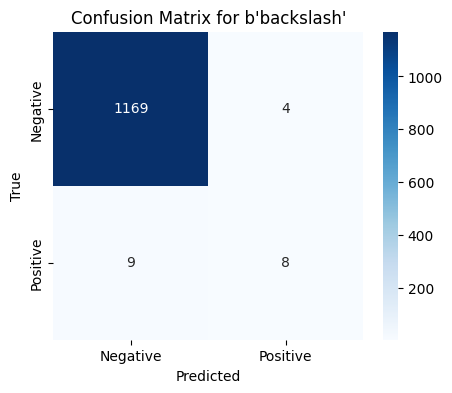

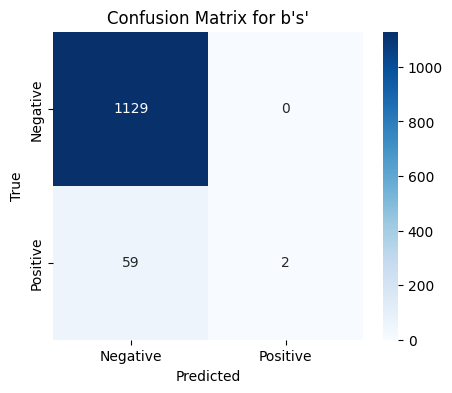

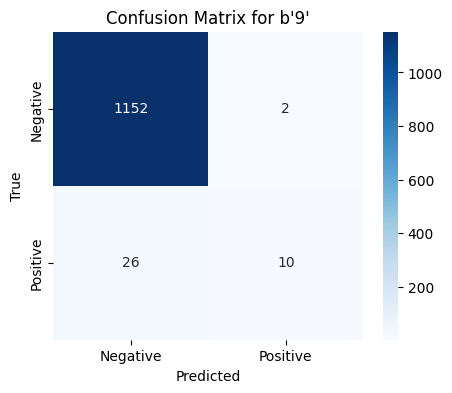

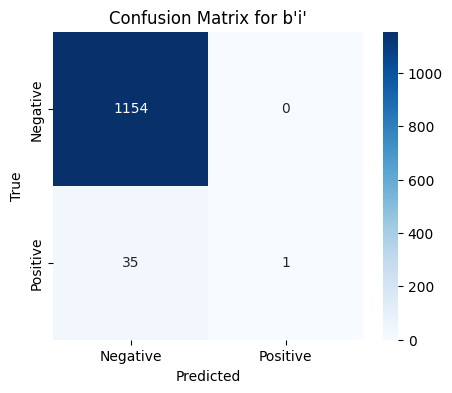

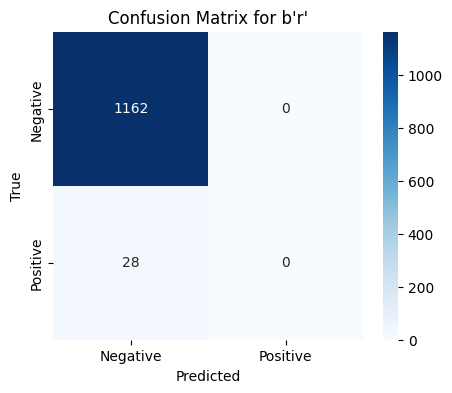

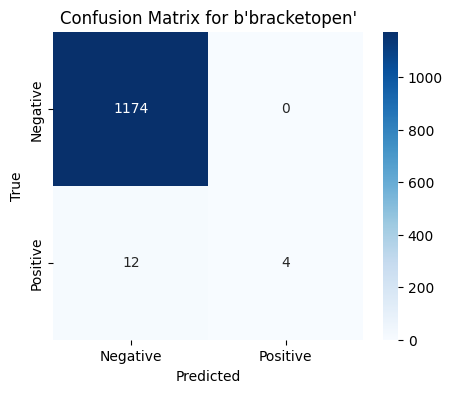

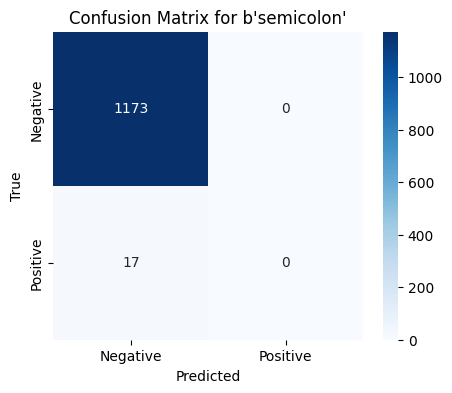

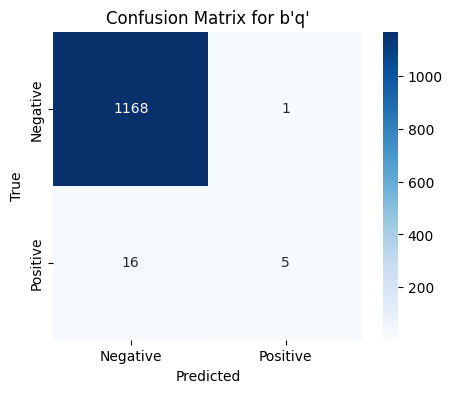

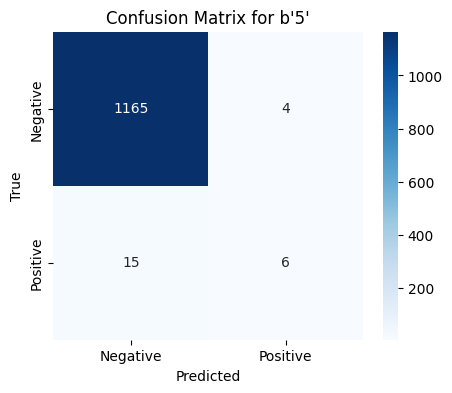

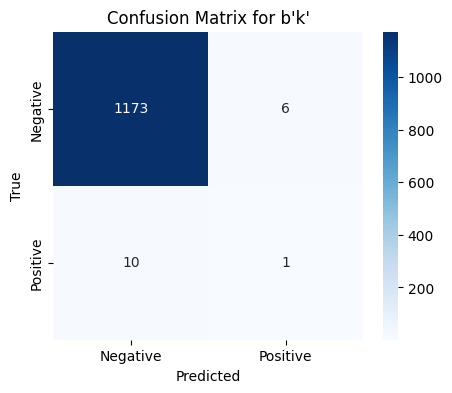

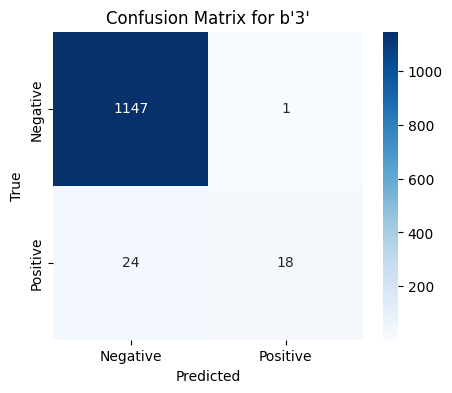

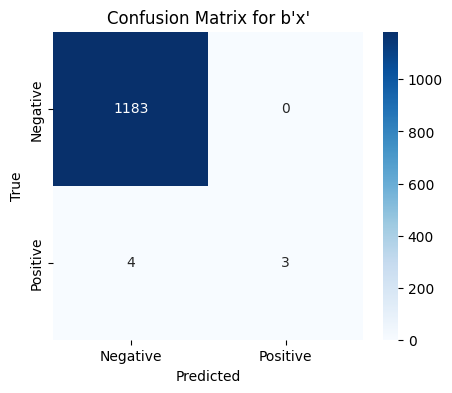

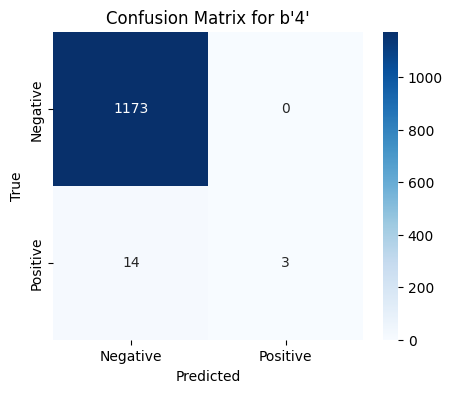

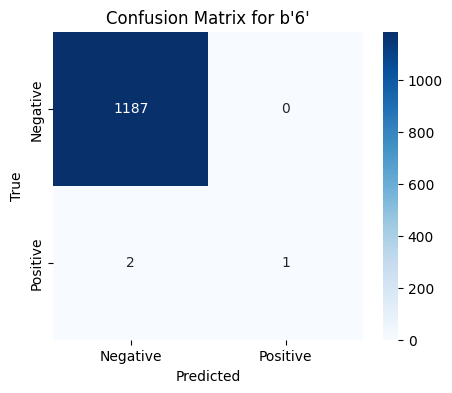

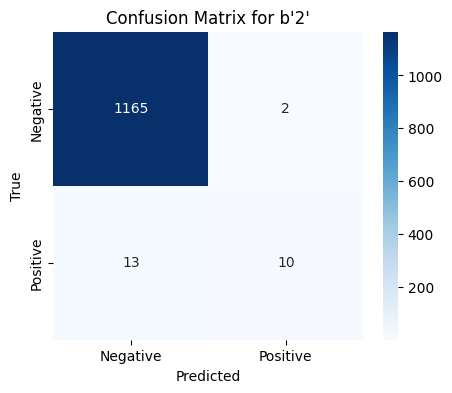

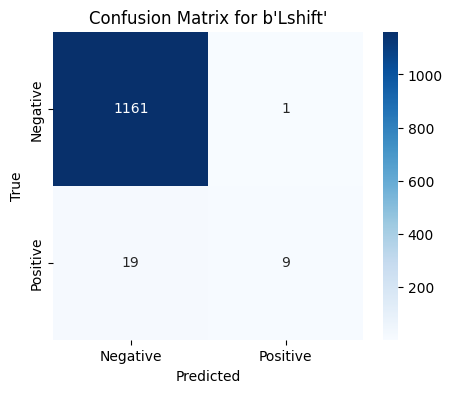

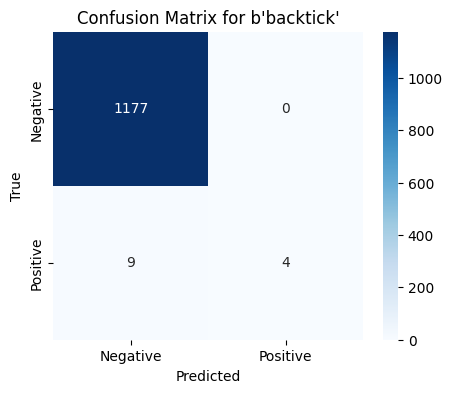

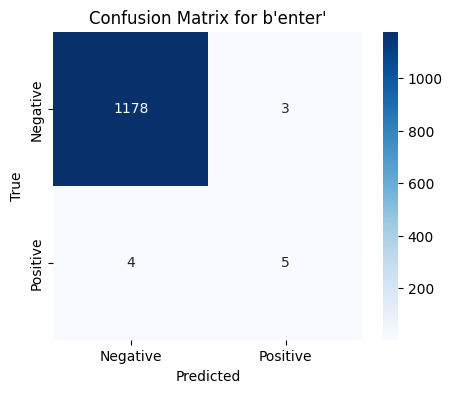

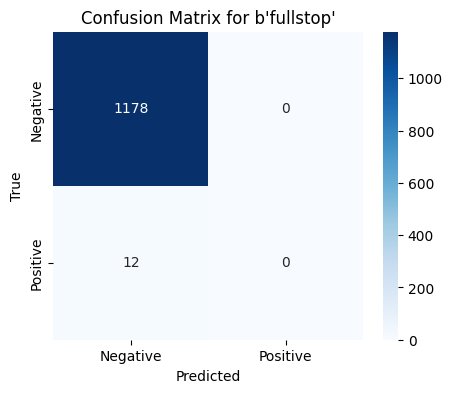

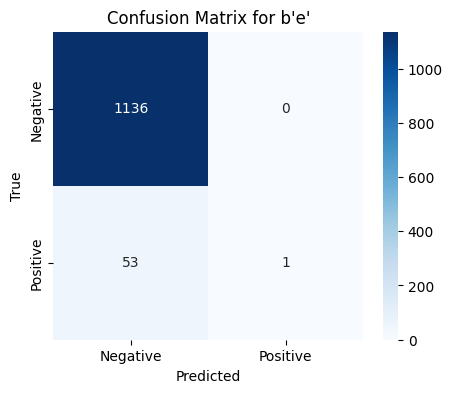

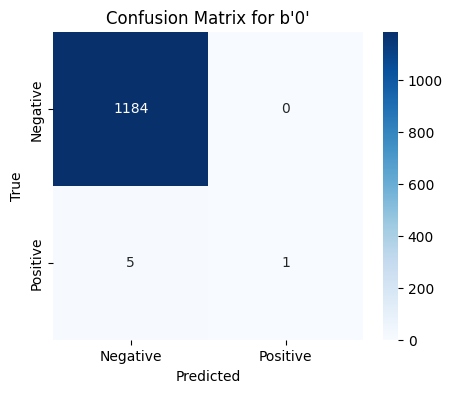

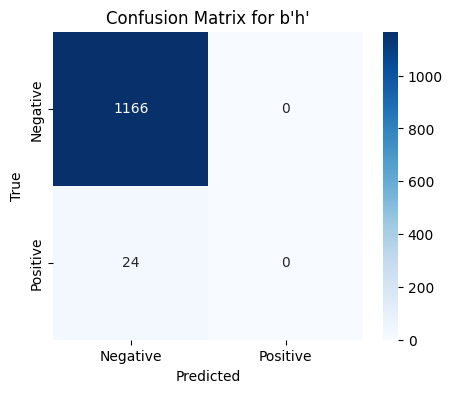

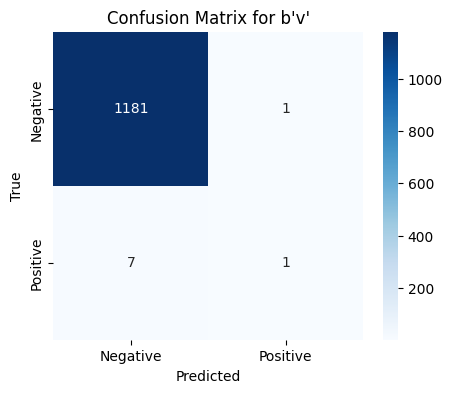

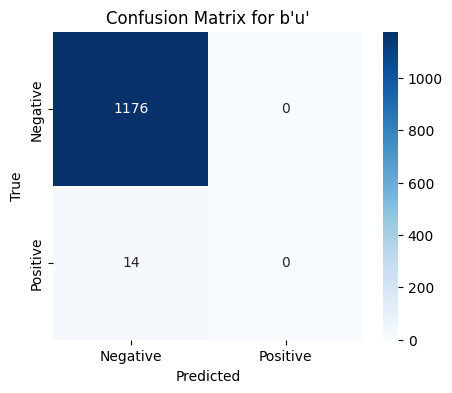

In [55]:
def plot_confusion_matrix(label_metrics):
    for x, label_name in enumerate(ALL_LABELS):
        metrics = label_metrics[f"Label {label_name}"]
        cm = np.array([[metrics["TN"], metrics["FP"]],
                       [metrics["FN"], metrics["TP"]]])
        
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.title(f"Confusion Matrix for {label_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


plot_confusion_matrix(label_metrics)


## Optimize Model

### Apply Quantization

In [56]:
tflite_weight_sharing_filename = "model.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open(tflite_weight_sharing_filename, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpqu48apui/assets


INFO:tensorflow:Assets written to: /tmp/tmpqu48apui/assets


Saved artifact at '/tmp/tmpqu48apui'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 19, 111, 1), dtype=tf.float32, name='keras_tensor_39')
Output Type:
  TensorSpec(shape=(None, 54), dtype=tf.float32, name=None)
Captures:
  140588780472976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140588780475264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140588780472800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140588780473856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140588780477904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140588780477728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140588780474384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140588780481600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140588780484064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140588780481248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14058878048

W0000 00:00:1733794676.379027 3792002 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733794676.379043 3792002 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-09 18:37:56.379182: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqu48apui
2024-12-09 18:37:56.379940: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-09 18:37:56.379949: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpqu48apui
2024-12-09 18:37:56.385681: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-09 18:37:56.425296: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpqu48apui
2024-12-09 18:37:56.434365: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 55185 microseconds.
